# Assignment 2: Scale-Space Blob Detection

### The goal of this assignment is to implement a Laplacian blob detector

Noel Mrowiec
10/1/2024
mrowiec3

In [3]:
# Libraries you will find useful
import numpy as np
import scipy 
import skimage
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps 
# for applying the Laplacian filter
from scipy.ndimage.filters import gaussian_laplace, maximum_filter

/tmp/ipykernel_1211/681115042.py:9: DeprecationWarning: Please import `gaussian_laplace` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_laplace, maximum_filter
/tmp/ipykernel_1211/681115042.py:9: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_laplace, maximum_filter


In [4]:
# Function to globally normalize a 2D array to the range [0, 1] 
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

In [5]:

# load each image 
dir_path = "images/"
images = []     #color images
filenames = []
for filename in os.listdir(dir_path):
    if filename.endswith('.jpg'):
        filenames.append(filename)
        img_path = os.path.join(dir_path, filename)
        img = Image.open(img_path)
        #img.show()  # This will display the image
        
        # convert images to grayscale
        img_gs = ImageOps.grayscale(img) 
        #img_gs.show()
        img_gs = np.array(img_gs).astype(float)
        img_gs = normalize(img_gs)
        images.append(img_gs)
        

print(f"Loaded {len(images)} images")

Loaded 4 images


In [6]:

def laplacian_gaussian(image, sigmas):
    scale_space = np.empty((image.shape[0],image.shape[1], len(sigmas)))

    for k, sigma in enumerate(sigmas):
        #sigma = get_sigma(k)
        lap_gaus = gaussian_laplace(image, sigma, mode='nearest') 
        scale_norm_LoG = (sigma ** 2) * lap_gaus                                                      #scale normalized
        scale_space[:,:,k] = scale_norm_LoG

    return scale_space

In [7]:
def non_max_suppression_3d(scale_space, sigmas, window_size = 5):

    # Non-maximum suppression in 3D
    footprint = np.ones((window_size, window_size, len(sigmas)))
    local_maxima = (scale_space == maximum_filter(scale_space, footprint=footprint))

    return local_maxima

In [8]:
def get_maxima_coords(scale_space, local_maxima, threshold):
    """
    returns: a list of coordinates of local maxima (x,y,sigma)
    """
    # Get coordinates of the local maxima
    coordinates = np.argwhere(local_maxima)
    
    x_coords, y_coords, z_coords = [], [], []
    # Filter coordinates by the threshold

    #source: Copilot
    for coord in coordinates:
        if scale_space[tuple(coord)] > threshold:
            h, w, d = coord
            x_coords.append(int(w))
            y_coords.append(int(h))
            z_coords.append(int(d))


    return [x_coords, y_coords, z_coords]

In [9]:
# constant
sqt_2 = 2**(1/2)
type(sqt_2)

float

In [10]:
# changing sigma
SIGMAS = [2,4,8,16,32]
coordinates_per_image = []

for image in images:
    lap_of_gauss = laplacian_gaussian(image, SIGMAS)
    #take absolute value
    lap_of_gauss = np.abs(lap_of_gauss)

    #threshold scale space
    threshold = np.percentile(lap_of_gauss, 78)
    # lap_of_gauss = threshold_scale_space(lap_of_gauss, threshold)

    #3D non-maximum suppression
    WINDOW_SIZE = 5
    local_maxima = non_max_suppression_3d(lap_of_gauss, SIGMAS, WINDOW_SIZE)
    coordinates = get_maxima_coords(lap_of_gauss, local_maxima, threshold)
    coordinates_per_image.append(coordinates)

In [11]:
from skimage.transform import resize

In [12]:
import scipy.ndimage

In [18]:
#changing image size
image_scales = [1,2,4,8,16,32]
coordinates_per_image_scaled = []


for image in images:
    print(f"size of image: {image.shape[0]}, {image.shape[1]}")
    scale_space = np.empty((image.shape[0],image.shape[1], len(image_scales)))
    #do image scale
    for k, scale in enumerate(image_scales):
        image_resized = resize(
            image, (image.shape[0] // scale, image.shape[1] // scale), anti_aliasing=True
        )
        lap_gaus = gaussian_laplace(image_resized, sigma=3, mode='nearest') 

        print(f"lap size {lap_gaus.shape}")

        # Calculate the zoom factor based on the original size
        zoom_factor = (image.shape[0] / lap_gaus.shape[0], image.shape[1] / lap_gaus.shape[1])

        # Zoom the Laplacian of Gaussian to the original size
        zoomed_image = scipy.ndimage.zoom(lap_gaus, zoom_factor, order=0)

        #image_interpol = scipy.ndimage.zoom(lap_gaus, scale, order = 0)
        scale_space[:,:,k] = zoomed_image


    #now scale_space has all image with LoG
    scale_space = np.abs(scale_space)

    #find threshold scale space
    threshold = np.percentile(scale_space, 78)

    #3D non-maximum suppression
    WINDOW_SIZE = 5
    local_maxima = non_max_suppression_3d(scale_space, image_scales, WINDOW_SIZE)
    coordinates = get_maxima_coords(scale_space, local_maxima, threshold)
    coordinates_per_image_scaled.append(coordinates)


size of image: 356, 493
lap size (356, 493)
Original size: (356, 493)
Zoomed size: (356, 493)
image_interpol size (356, 493)
lap size (178, 246)
Original size: (356, 493)
Zoomed size: (356, 493)
image_interpol size (356, 493)
lap size (89, 123)
Original size: (356, 493)
Zoomed size: (356, 493)
image_interpol size (356, 493)
lap size (44, 61)
Original size: (356, 493)
Zoomed size: (356, 493)
image_interpol size (356, 493)
lap size (22, 30)
Original size: (356, 493)
Zoomed size: (356, 493)
image_interpol size (356, 493)
lap size (11, 15)
Original size: (356, 493)
Zoomed size: (356, 493)
image_interpol size (356, 493)
size of image: 357, 328
lap size (357, 328)
Original size: (357, 328)
Zoomed size: (357, 328)
image_interpol size (357, 328)
lap size (178, 164)
Original size: (357, 328)
Zoomed size: (357, 328)
image_interpol size (357, 328)
lap size (89, 82)
Original size: (357, 328)
Zoomed size: (357, 328)
image_interpol size (357, 328)
lap size (44, 41)
Original size: (357, 328)
Zoomed s

In [339]:


# filtering the image (two implementations)
# one that increases filter size, and one that downsamples the image
# For timing, use time.time()



# To display the detected regions as circle
from matplotlib.patches import Circle
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cy))

    plt.show()

image size (356, 493)
num of images 4
x :<class 'int'>, y <class 'int'>, radii <class 'float'>


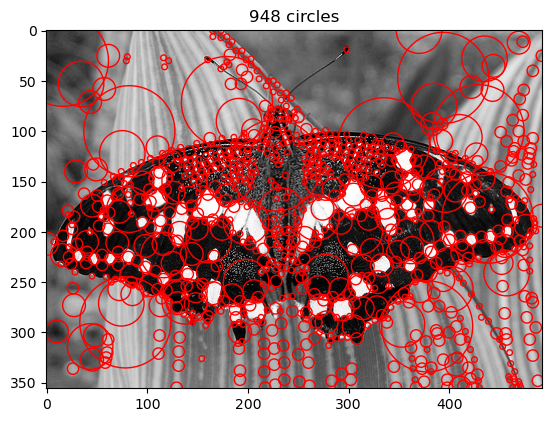

x :<class 'int'>, y <class 'int'>, radii <class 'float'>


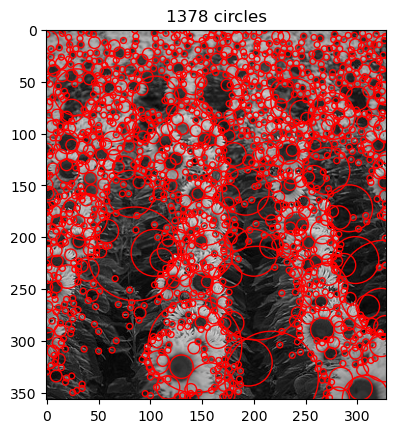

x :<class 'int'>, y <class 'int'>, radii <class 'float'>


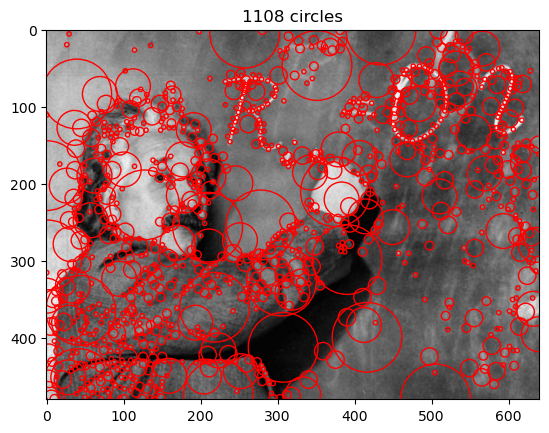

x :<class 'int'>, y <class 'int'>, radii <class 'float'>


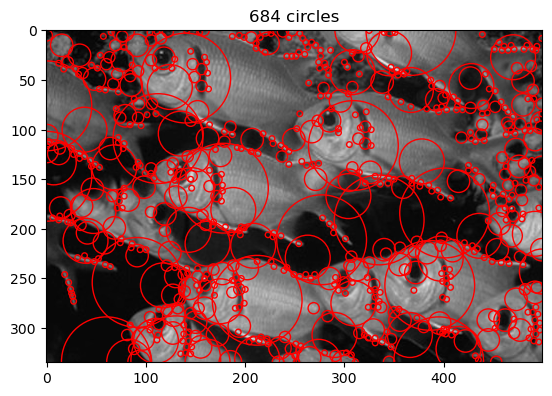

In [340]:


print(f"image size {images[0].shape}")
print(f"num of images {len(coordinates_per_image)}")

for i, coords in enumerate(coordinates_per_image):
   
    cx, cy, cz = coords
    sigmas = np.array([SIGMAS[z] for z in cz])
    radii = sigmas * sqt_2
    radii = radii.tolist()

    print(f"x :{type(cx[0])}, y {type(cy[0])}, radii {type(radii[0])}")
    show_all_circles(images[i], cx, cy, radii)
#show_all_circles(images[0], [55,33,88,10], [76,350,12,100], [5,7,1,2])

In [ ]:
#scaled images

print(f"image size {images[0].shape}")
print(f"num of images {len(coordinates_per_image)}")

for i, coords in enumerate(coordinates_per_image):
   
    cx, cy, cz = coords
    sigmas = np.array([SIGMAS[z] for z in cz])
    radii = sigmas * sqt_2
    radii = radii.tolist()

    print(f"x :{type(cx[0])}, y {type(cy[0])}, radii {type(radii[0])}")
    show_all_circles(images[i], cx, cy, radii)